<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-9/Avance9_Equipo10_Evaluation_llama_3_8b_Instruct_bnb_4bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

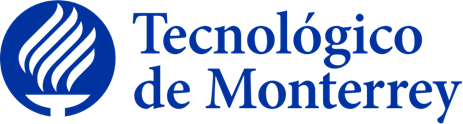

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Evaluación Modelo Final**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

In this notebook we will be evaluating our final model. The library that we will use for the model evaluation is Deepeval.

### 1. First, we load the libraries

In [1]:
# Installs Unsloth, Xformers (Flash Attention) and all other packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install datasets
!pip install deepeval
!pip install python-dotenv

from deepeval import evaluate
from deepeval.evaluate import aggregate_metric_pass_rates
from deepeval.metrics import AnswerRelevancyMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from unsloth import FastLanguageModel
#from peft import PeftModel
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import json
from dotenv import load_dotenv
#from transformers.tokenization_utils_base import PreTrainedTokenizerBase
#from transformers.modeling_utils import PreTrainedModel

from deepeval.dataset.golden import Golden
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import re


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-0nn0acl8/unsloth_b8e8081de7dd43eaa3f5286184b05743
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-0nn0acl8/unsloth_b8e8081de7dd43eaa3f5286184b05743
  Resolved https://github.com/unslothai/unsloth.git to commit 9b4802f73268a12c0f057f3598c65bf3f5704bba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Activated, the notebook will execute only a few testcases for demostrantion purposes
#demo_mode = False
#model_name = "unsloth/mistral-7b-v0.3-bnb-4bit"
dataset_url = "JonathanGarza/legal-mx-instruction-dataset-0-6-inst-ft-prompts"
#peft_model_name = 'rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2'

In [112]:
#model, tokenizer = FastLanguageModel.from_pretrained(
    #model_name = model_name,
    #max_seq_length = 2048,
    #device_map='cuda',
    #load_in_4bit = True,
#)

#Load fine tuned model

max_seq_length = 4096

model_fine_tuned, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "JonathanGarza/unsloth-llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2", # MODEL YOU USED FOR TRAINING
        #model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length, # Could be any since RoPE Scaling is supported.
        dtype = None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
        load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
        )
FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 2. Functions Definition

In this section we define a few helper functions that we will be using for setting the test cases and generating the response from our model.

In [5]:
def extract_response(response: str) -> str|None:
    '''
    This function extracts only the answer from the model output
    '''
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    '''
    Create a test case from a dictionary of datapoints
    '''
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )

#def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
def query(model: model_fine_tuned, tokenizer:tokenizer,prompt: str) -> str:
    '''
    Generates the response from the model
    '''

    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = max_seq_length, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)

    return extract_response(result[0])

#def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
def generate_test_cases(model: model_fine_tuned, tokenizer: tokenizer, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
    '''
    Generates all the test cases from a list of datapoints (called Goldens in deepeval)
    '''
    test_cases = []

    if isinstance(datapoints, Dataset):
        datapoints = convert_hugging_face_dataset_to_goldens(datapoints)
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        print(datapoint)

        if (isinstance(golden, Golden)):
            datapoint = json.loads(golden.model_dump_json())

        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                #datapoint['instruction'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases

def exclude_test_cases_with_empty_outputs(testcases: list[LLMTestCase], print_results = True)->list[LLMTestCase]:
    cleaned_testcases = []
    for index,testcase in enumerate(testcases):
        if type(testcase.actual_output) == str:
            cleaned_testcases.append(testcases.pop(index))
            continue

    if print_results:
        print (f'A total of {len(testcases) - len(cleaned_testcases)} testcases were removed from the set')
    return cleaned_testcases

def convert_hugging_face_dataset_to_goldens(dataset: Dataset)->list[Golden]:

    goldens = []

    for datapoint in dataset:
        if (type(datapoint['context']) != str):
            continue#We need context for some tests
        test_case = Golden(
            input = datapoint['instruction'],
            expected_output = datapoint['output'],
            context = [datapoint['context']]
        )

        test_case.expected_output = datapoint['output']

        goldens.append(test_case)

    return goldens




In [152]:
#Developing new test cases function

def create_text_cases(model_fine_tuned, tokenizer, prompt, dataset, max_new_tokens):

  EOS_TOKEN = tokenizer.eos_token

  test_cases = []

  FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

  data_set_counter = 0

  none_context_counter = 0

  none_output_counter = 0

  for i in range(len(dataset)):

    data_set_counter = data_set_counter + 1

    context = dataset[i]['context']

    if context != None:

      context_tokens = tokenizer(dataset[i]['context'])
      input_ids = context_tokens['input_ids']
      portioned_context = ''.join(tokenizer.batch_decode(input_ids)[1:100])
      #portioned_context = dataset[i]['context']

      context = [context]

      #print(row)

      text_inputs = [
        alpaca_based_prompt.format(
          dataset[i]['instruction'], # Instrucción
          portioned_context, # Contexto
          #None,
          "", # Salida - leave this blank for generation
          ) #+ EOS_TOKEN
      ]

      #print('Inputs: {}\n\n'.format(text_inputs))

      inputs = tokenizer(
      [
      alpaca_based_prompt.format(
          dataset[i]['instruction'], # Instrucción
          portioned_context, # Contexto
          #None,
          "", # Salida - leave this blank for generation
          ) #+ EOS_TOKEN
      ], return_tensors = "pt").to("cuda")

      outputs_fine_tuned = model_fine_tuned.generate(**inputs, max_new_tokens = max_new_tokens, use_cache = True, pad_token_id = tokenizer.eos_token_id)
      outputs_fine_tuned_decoded = tokenizer.batch_decode(outputs_fine_tuned)

      model_fined_tuned_response = extract_response(outputs_fine_tuned_decoded[0])

      #print('Response: '+model_fined_tuned_response)
      #print('Context: {}'.format(context))

      if model_fined_tuned_response != None:

        test_case = LLMTestCase(
          input = dataset[i]['instruction'],
          actual_output = model_fined_tuned_response,
          context = context,
          expected_output = dataset[i]['output']
          )

        test_cases.append(test_case)
        none_output_counter = none_output_counter + 1
        print('Element {} from {}'.format(i, len(dataset)))


    else:

      none_context_counter = none_context_counter + 1

  print ('Total None Context Elements: {}'.format(none_context_counter))
  print ('Total None Output Elements: {}'.format(none_context_counter))
  print ('Total Test Cases: {}'.format(len(test_cases)))

  return test_cases

In [87]:
#context_tokens = tokenizer(dataset[0]['context'])
#input_ids = context_tokens['input_ids']
#portioned_context = ''.join(tokenizer.batch_decode(input_ids)[1:21])
#portioned_context

### 2. Creating the test dataset

For creating the dataset, we need to access OpenAI Api since we'll be using a synthetic dataset created from the law files used for this project.

In [125]:
dataset = load_dataset(dataset_url, split = "test[0:100]")
#test_set = dataset['test']

In [8]:
#We need a API key. Please, be sure to have a .env file in the same directory of this notebook.
import os
#We need a API key .env path
dot_env_path = '/content/drive/MyDrive/MNA/Proyecto Integrador/.env'

#Load .env file
load_dotenv(dot_env_path)

#Get API Key
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

### 3. Setting up the Finetuned Model

We proceed to download the main model, which was a quantized version of the Llama-3-8b. In order to run this code, it'necessary to have cuda device.

Now we donwload the PEFT model containing the trained weights

In [9]:

#model = PeftModel.from_pretrained(model, model_id=peft_model_name)
#FastLanguageModel.for_inference(model)

We define the prompt that we will provide to the Llama Model

In [10]:
#Base prompt
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción

### Instrucción:
{}

### Contexto:
{}

### Respuesta:
{}"""

### 4. Evaluating the Model

First, let's load the dataset containing all the goldens

Now, we create the test cases from the goldens. For the real evaluation we used 250+ testcases, For demonstration purposes, we will use only 10 testcases.

In [11]:
#len(test_set)
len(dataset)

4

In [12]:
#for row in dataset:
#  print('Context: {}\n\n'.format([row['context']]))

In [13]:
#dataset = test_set.train_test_split(test_size=0.2)

In [122]:
#dataset[59]

In [15]:
#for row in dataset:
#
#  context = row['context']
#  if context != None:

#    context = [context]

#  test_case = LLMTestCase(
#    input=row['instruction'],
#    actual_output=row['output'],
#    context = context
#    )

In [16]:
#print(test_case)

In [17]:
#print(dataset[0]['context'])

In [153]:
#test_cases = generate_test_cases(model_fine_tuned, tokenizer, dataset, alpaca_based_prompt)
test_cases = create_text_cases(model_fine_tuned, tokenizer, alpaca_based_prompt, dataset, max_seq_length)

Element 0 from 100
Element 1 from 100
Element 2 from 100
Element 3 from 100
Element 4 from 100
Element 5 from 100
Element 6 from 100
Element 7 from 100
Element 8 from 100
Element 9 from 100
Element 11 from 100
Element 12 from 100
Element 13 from 100
Element 14 from 100
Element 15 from 100
Element 16 from 100
Element 17 from 100
Element 18 from 100
Element 19 from 100
Element 20 from 100
Element 21 from 100
Element 22 from 100
Element 23 from 100
Element 24 from 100
Element 25 from 100
Element 26 from 100
Element 27 from 100
Element 28 from 100
Element 29 from 100
Element 30 from 100
Element 31 from 100
Element 32 from 100
Element 33 from 100
Element 34 from 100
Element 35 from 100
Element 36 from 100
Element 37 from 100
Element 38 from 100
Element 39 from 100
Element 40 from 100
Element 41 from 100
Element 42 from 100
Element 43 from 100
Element 44 from 100
Element 45 from 100
Element 46 from 100
Element 47 from 100
Element 48 from 100
Element 49 from 100
Element 50 from 100
Element 51

In [154]:
for i in range(len(test_cases)):
    if test_cases[i].actual_output == None:
      print(i)

Sometimes the Llama model generates an empty response. Due to time constraints, we were not able to investigate this unexpected behaviour. Since a testcase with empty output would generate an error during evaluation, we must exclude it here from the test dataset.

In [40]:
#test_cases = exclude_test_cases_with_empty_outputs(test_cases)

A total of -1 testcases were removed from the set


In [ ]:
#dataset_test_cases = EvaluationDataset(test_cases)

In [129]:
from deepeval.dataset.utils import convert_test_cases_to_goldens

goldens = convert_test_cases_to_goldens(test_cases)

In [163]:
backup_dataset = EvaluationDataset(goldens = goldens)
backup_dataset.save_as('json', '/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100')

Evaluation dataset saved at /content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100/20240616_032054.json!


'/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100/20240616_032054.json'

We will evaluating our model against three metrics:

* Hallucination
* Correctness
* Answer Relevancy

The evaluation process uses GPT-3.5-turbo under the hood. So, it's necessary to have an OpenAI Key in order to run this section of the notebook.

On another note, we are using conservative threshold values since all the datasets that were used in this project were synthetic. It's reasonable to expect that the model's performance has been affected by this.

In [ ]:
#with open('./content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases'):

In [33]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

In [ ]:
#hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
#correctness_metric = GEval(
#    threshold=0.7,
#    model='gpt-3.5-turbo',
#    name="Correctness",
#    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
#    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
#)
#answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

No we get the results from the evaluation

In [155]:
results = evaluate(test_cases, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=False, print_results=False)

Event loop is already running. Applying nest_asyncio patch to allow async execution...


/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/uti

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

In [161]:
results

[TestResult(success=False, metrics=[<deepeval.metrics.hallucination.hallucination.HallucinationMetric object at 0x7a820ba81660>, <deepeval.metrics.answer_relevancy.answer_relevancy.AnswerRelevancyMetric object at 0x7a820ba81d50>, <deepeval.metrics.g_eval.g_eval.GEval object at 0x7a820ba82770>], input='¿Qué información debe enviar el Banco de México al Ejecutivo Federal y al Congreso de la Unión según el Artículo 51 de la Ley del Banco de México?', actual_output='El Banco de México debe enviar al Ejecutivo Federal y al Congreso de la Unión, en enero de cada año, una exposición sobre la política monetaria a seguir en el ejercicio respectivo, así como un informe sobre el presupuesto de gasto corriente e inversión física.<|eot_id|>', expected_output='El Banco de México debe enviar al Ejecutivo Federal y al Congreso de la Unión una exposición sobre la política monetaria a seguir por la Institución en el ejercicio respectivo en enero de cada año, así como un informe sobre el presupuesto de g

In [162]:
with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results') as f:
    results = json.load(f)

clean_results = []
for test_case in results['testCases']:
    for metric in test_case['metricsMetadata']:
        if 'error' in metric and metric['error'] == 'Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.':
           continue


        clean_results.append(metric)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results'

In [ ]:
#len(clean_results)

In [117]:
#clean_results[10]
#results['metric']

TypeError: list indices must be integers or slices, not str

In [ ]:
#clean_results[0]

In [ ]:
#hallucination_metric = []
#for metric in clean_results:
#for metric in results:
#        if metric['metric'] == 'Hallucination':
#            hallucination_metric.append(metric)



#hallucination_metric[0]

TypeError: 'TestResult' object is not subscriptable

In [ ]:
#len(hallucination_metric)

0

In [ ]:
#passed = 0

#for metric in hallucination_metric:
#    if metric['success'] == True:
#        passed+=1


#passed/len(hallucination_metric)

ZeroDivisionError: division by zero

In [ ]:
#len(hallucination_metric)

In [ ]:
#passed

Now we print the scores:

In [159]:
print('Fine tuned model results:\n\n')
scores_fine_tuned = aggregate_metric_pass_rates(results)

#if not demo_mode:
#    with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results/test_results.json', 'w') as f:
#        json.dump(scores, f)

Fine tuned model results:




Overall Metric Pass Rates

HallucinationMetric: 78.12% pass rate
AnswerRelevancyMetric: 84.38% pass rate
GEval: 76.04% pass rate




In [158]:
#Load fine tuned model

model_base, tokenizer_base = FastLanguageModel.from_pretrained(
        model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        #model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length, # Could be any since RoPE Scaling is supported.
        dtype = None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
        load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
        )
FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [160]:
#test_cases = generate_test_cases(model_fine_tuned, tokenizer, dataset, alpaca_based_prompt)
base_test_cases = create_text_cases(model_base, tokenizer_base, alpaca_based_prompt, dataset, max_seq_length)

Element 1 from 100
Element 4 from 100
Element 6 from 100
Element 7 from 100
Element 8 from 100
Element 13 from 100


KeyboardInterrupt: 

In [ ]:
results_base = evaluate(base_test_cases, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=False, print_results=False)

In [ ]:
print('Base model results:\n\n')
scores_base = aggregate_metric_pass_rates(results_base)

In case the notebook is in demo mode, we load the real scores and print them out:

In [ ]:
#if demo_mode:
#    with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results/test_results.json') as f:
#        scores = json.load(f)

#    print("\n" + "=" * 70 + "\n")
#    print("Overall Metric Pass Rates\n")
#    for metric, pass_rate in scores.items():
#        print(f"{metric}: {pass_rate:.2%} pass rate")
#    print("\n" + "=" * 70 + "\n")


NameError: name 'demo_mode' is not defined

### 5. Conclusions

The model has a good performance on the GEval and Answer Relevancy metrics (92.62% and 89.93$ respectively). Nonetheless, the hallucination metric is not satisfactory (4.03%) and must be improved. There are several steps that can be taken in order to improve this metric:

* Train the model in a larger dataset (currently we used 5,000 entries)
* Use human annotators for creating high quality datasets
* Train other models and compare to the one used in this project.

Because the model has low score in the hallucination metric, it's still not ready for production.